In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import pdir as pr

# 数据集处理

本次数据分为 train.csv 和 test.csv。每个文件有4列，前39列为特征，最后一列是标签（只有1和0两种取值）。

## 数据集读取函数实现

In [3]:
def loadDataSet(filePath):
    ''' 数据集读取函数'''
    data, label = [], []
    # 读取数据集
    with open(filePath) as f:
        for line in f.readlines():
            temp = line.strip().split(",")
            data.append([float(i) for i in temp[:-1]])
            if temp[-1] != '?':
                temp[-1] = float(temp[-1])
            label.append(temp[-1])
    ##### 输出数据集相关信息 ##########
    print("data dimension of dataset：", len(data[0]))
    print("number of sample in data :", len(data))
    print("label frequency:", dict(Counter(label)))
    ##### 输出数据集相关信息 ##########
    return np.array(data), np.array(label)

## 读取原始训练集

In [5]:
trainSet_origin, trainSet_label_origin = loadDataSet('.\\data\\train.csv')
trainSet_origin

data dimension of dataset： 40
number of sample in data : 8000
label frequency: {0.0: 4040, 1.0: 3960}


## 读取测试集

In [6]:
testSet, testSet_lable = loadDataSet('.\\data\\test.csv')
testSet

data dimension of dataset： 40
number of sample in data : 2000
label frequency: {'?': 2000}


## 从训练集中划分验证集

典型的从训练集中划分验证集的方法是：划分训练集中的30%为验证集，划分过程采用随机选取的方式。

In [7]:
def splitTrainSet2ValidateSet(trainSet_, trainSet_label_, rate=0.3):
    '''从训练集中划分验证集'''
    #整合数据集和对应标签在同一个数组上，方便后续划分
    allData = np.column_stack((trainSet_, trainSet_label_))
    #随机打乱数据集
    np.random.shuffle(allData)
    #得到要划分的验证集的样本个数
    splitNum = int(allData.shape[0]*rate)
    #划分数据集
    validateSet_ = allData[:splitNum, :-1]
    validateSet_label_ = allData[:splitNum, -1]
    trainSet_new = allData[splitNum:, :-1]
    trainSet_label_new = allData[splitNum:, -1]
    return trainSet_new, trainSet_label_new, validateSet_, validateSet_label_

temp = splitTrainSet2ValidateSet(trainSet_origin, trainSet_label_origin)
trainSet, trainSet_label, validateSet, validateSet_label = temp
print('划分后的验证集和训练集的维度：', validateSet.shape, trainSet.shape)

划分后的验证集和训练集的维度： (2400, 40) (5600, 40)


# 逻辑回归算法

## 算法原理

逻辑回归是一种二分类算法，在本次实验中，分类标签便只有0和1两种取值。

这里用 $y$ 来表示分类标签，则有 $y\in\{0,1\}$。

用  $X=[x_1,x_2,...,x_d]$ 来表示单个数据样本，其中 $x_i$ 是 $X$ 在第 $i$ 个维度的取值。

逻辑回归的目标就是：建立一个模型，使得在给定数据 $X$ 的前提下，可以求该数据分类为 $y$ 的概率$P(y|X)$。

逻辑回归借鉴了PLA的建模思路，对于数据集的d维特征，每个特征都有一个加分权重 $w_i$，因此总的加分值为

$$score = \sum_{i=1}^dw_i*x_i+\theta$$

其中，$\theta$ 为阈值，为了方便，这里可令$\theta=w_0$，因此可拓展上式为：

$$score = \sum_{i=0}^dw_i*x_i=W^TX$$

这里$W^T=[w_0,w_1,...,w_d]$，$X$拓展为$X=[1, x_1,x_2,...,x_d]$

而若要求解概率$P(y|X)$，显然需要找到一种方法将上面的加分值通过某种方式映射到$[0,1]$之间。

这里逻辑回归便引入了sigmoid函数来实现这一目标，其定义为:$$\theta(x)=\frac{1}{1+e^{-x}}$$

该函数的定义域为$[-\infty ,+\infty]$，值域为$(0,1)$，则：

$$\theta(score)=\frac{1}{1+e^{-W^TX}}\in (0,1)$$

逻辑回归视 将由 $X$ 计算得来的加分值 代入上式后得到的值 为$X$属于正分类的概率：

- 当$score \rightarrow -\infty,\theta(score) \rightarrow 0$，便认为$P(y=1|X)$为 0

- 当$score =0,\theta(score) =0.5$，便认为$P(y=1|X)$为0.5

- 当$score \rightarrow +\infty,\theta(score) \rightarrow 1$，便认为$P(y=1|X)$为 1

利用该函数，逻辑回归建立了如下的假说模型：$$h(X)=\frac{1}{1+e^{-W^TX}}$$

当$y=1$时，$P(y=1|X)=h(X)$；当$y=0$时，$P(y=0|X)=1-h(X)$；

为了方便，可将上面的两种情况合并为一条式子：$$P(y|X,W)=h(x)^y(1-h(x))^{1-y}$$

逻辑回归的目标便是要求出一个最理想的$W$，即：

$$\mathop{\arg\max}_{W} P(y|X,W)=\mathop{\arg\max}_{W}h(x)^y(1-h(x))^{1-y}$$

对于给定一个训练集$D={(X_1,y_1),(X_2,y_2),...,(X_n,y_n)}$，逻辑回归的优化目标则为：

$$
\mathop{\arg\max}_{W} \prod_{i=1}^n P(y_i|X_i,W)
\\\iff
\mathop{\arg\max}_{W}\prod_{i=1}^n h(x)^y_i(1-h(x))^{1-y_i}
$$

$$
\\\iff
\mathop{\arg\min}_{W} -\prod_{i=1}^n h(x)^y_i(1-h(x))^{1-y_i}
\\\iff
\mathop{\arg\min}_{W} -ln(\prod_{i=1}^n h(x)^y_i(1-h(x))^{1-y_i})
$$

$$
\\\iff
\mathop{\arg\min}_{W} \sum_{i=1}^n[y_i*ln(h(X_i)+(1-y_i)*ln(1-h(X_i))]
$$

注：这里为了求解方便，使用了对数变换，其不改变函数的极值点和最优解，并通过添加一个负号来将原来的最大化问题转换为最小化问题。

令$$Err(W)=\sum_{i=1}^n[y_i*ln(h(X_i)+(1-y_i)*ln(1-h(X_i))]$$

可以证明，$Err(W)$是一个连续可导，二阶可微的凸函数，其存在全局最优解。

而由于直接求解 $Err(W)$ 的最优解比较困难，故我们采取梯度下降法来求解其最优解。

$Err(W)$ 的在第 $j$ 个维度的梯度求解后为:

$$\bigtriangledown Err(W_j)=\sum_{i=1}^n[(\frac{1}{1+e^{-W^TX}}-y_i)x_{i,j}]$$

在求解了$Err(W)$在所有的维度的梯度之后，便可根据如下式子进行更新了。

$$W_{t+1}=W_{t}-\eta \triangledown Err(W_t)$$

其中，$\eta$为人工设置的步长。

算法伪代码见下部分。

## 算法伪代码

---

**逻辑回归算法**

---
**输入**：训练集$D={(X_1,y_1),(X_2,y_2),...,(X_n,y_n)}$、梯度下降的步长$\eta$、算法中的迭代次数**maxRunTimes**

**输出**：最优模型参数$W_{t+1}$

---
1:初始化$W$为n+1维的向量，其值全部为1

2:给训练集 **D** 中的每一个样本前加一个常数1

3:$for\ t\ =\ 1,2,...,maxRunTimes\ do$

4:$\ \ \ \ \ for\ j\ =\ 1,2,...,d\ do$

5:$\ \ \ \ \ \ \ \ \ \ $计算整个数据集在维度j的梯度：

$$\bigtriangledown Err(W_j)=\sum_{i=1}^n[(\frac{1}{1+e^{-W^TX}}-y_i)x_{i,j}]$$

6:$\ \ \ \ \ endfor$

7:$\ \ \ \ \ for\ j\ =\ 1,2,...,d\ do$

8:$\ \ \ \ \ \ \ \ \ \ $迭代更新$W$在维度j的取值：

$$W_{t+1,j}=W_{t,j}-\eta \triangledown Err(W_{t,j})$$

9:$\ \ \ \ \ endfor$

10:$endfor$

---


## 算法实现

In [12]:
class LogisticRegression:
    '''逻辑回归类实现'''
    
    def __addOne2Samples(self, dataSet):
        '''给每一个样本前加一个常数1'''
        ones = np.ones(len(dataSet))
        return np.column_stack((ones, dataSet))
    
    def sigmoid(self, x):
        '''sigmoid函数实现'''
        return 1/(1+np.exp(-1*x))
    
    def fit(self, trainSet, label, eta=1e-3, maxRunTimes=100, reduceEta=True):
        '''根据给定的训练集和标签训练PLA的参数 w '''
        #设置默认的 w 全为1
        self.w = np.mat(np.ones(trainSet.shape[1]+1)).reshape(-1,1)
        #给训练集中每一个样本前加一个常数1，并转换为numpy矩阵
        trainSet = np.mat(self.__addOne2Samples(trainSet))
        #将标签转换为numpy矩阵，并将其设置为只有一列的数据的矩阵
        label = np.mat(label).reshape(-1,1)
        eta_reduced = eta
        for i in range(maxRunTimes):
            if reduceEta:
                eta_reduced = eta/(1+i)+1e-7
            #根据矩阵运算得到整个数据集每个维度梯度
            gradient = trainSet.transpose()*(self.sigmoid(trainSet*self.w) - label)
            #print("第"+str(i+1)+"次迭代的梯度值：\n", gradient)
            #更新 w
            self.w -= eta_reduced*gradient
        
    def __apply(self, x):
        '''利用训练好的 w 对输入的向量x进行分类'''
        w = np.array(self.w)[:,0] #转换为numpy向量，方便后续计算
        return 1 if self.sigmoid(np.dot(w, x)) > 0.5 else 0
    
    def apply(self, otherSet):
        '''根据已训练出的 w 对其他数据集进行划分'''
        otherSet = self.__addOne2Samples(otherSet)
        outputLabel = np.zeros(otherSet.shape[0])
        for index, sample in enumerate(otherSet):
            outputLabel[index] = self.__apply(sample)
        return outputLabel
    
    def getW(self):
        return np.array(self.w)[:,0]

### 优化思路

1.**向量化运算**：使用Numpy库的矩阵运算来实现算法的向量化运算。

2.**动态调整步长**：假设当前迭代次数为 $i$, $i$从0开始计数，根据迭代次数使用下式动态地调整步长：

$$\eta=\frac{\eta_{origin}}{1+i}+10^{-7}$$

其中，$\eta_{origin}$是预先给定的$\eta$值。

## 小数据集测试

In [11]:
############测试程序###################
c = [[1,2],[2,-1]] #trainset
d = [1, 0]         #label
e = [[3,3]]        #otherset

LR = LogisticRegression()
LR.fit(np.array(c), d, eta=1, maxRunTimes=1, reduceEta=False)
print("\n最终训练出来的 w 为：", LR.getW())
print("\n预测分类：", LR.apply(e))
############测试程序###################

第1次迭代的梯度值：
 [[ 0.86281087]
 [ 1.74360795]
 [-0.9167695 ]]

最终训练出来的 w 为： [ 0.13718913 -0.74360795  1.9167695 ]

预测分类： [ 1.]


---

下面根据测试数据以及输出来验证算法实现的正确性。

首先，给定的训练集为c，c中有两个样本数据：[1, 2]和[2, -1]，从d可知两者对应的分类标签为1和0。

初始设置 $w_0$ 全为1，阈值 $\theta$ 设置为1。

那么在样本的第一个维度插入1后，即有：

```
***********************************************
      训练集                      测试集          
----------------------------   --------------  
     样本           标签            样本
x1 = [1,  1,  2]  |  y1 =  1   x3 = [1, 3, 3]
x2 = [1,  2, -1]  |  y2 =  0

算法参数 w 初始设置为： [1, 1, 1]
***********************************************
```

这里 $\eta$ 设置为1，迭代次数设置为1次。

第一次迭代时，$w_0=[1, 1, 1]$，并且数据集的每个样本的权重分数为：

$$
\begin{bmatrix}
1 & 1 & 2\\ 
1 & 2 & -1
\end{bmatrix}
*
\begin{bmatrix}
1 \\ 
1 \\
1
\end{bmatrix}
=
\begin{bmatrix}
4\\ 
2 
\end{bmatrix}
$$

即 $x_1$ 和 $x_2$ 各自的权重分数为 4 和 2。

整个数据集的梯度为：

$$
gradient=\begin{bmatrix}
1 & 1\\ 
1 & 2\\
2 & -1
\end{bmatrix}
*(
sigmoid
(\begin{bmatrix}
4\\ 
2
\end{bmatrix})-
\begin{bmatrix}
1\\ 
0
\end{bmatrix}
)=
\begin{bmatrix}
1 & 1\\ 
1 & 2\\
2 & -1
\end{bmatrix}
*
\begin{bmatrix}
\frac{1}{1+e^{-4}} -1\\ 
\frac{1}{1+e^{-2}} -0
\end{bmatrix}
$$

$$
=
\begin{bmatrix}
1*(\frac{1}{1+e^{-4}} -1) + 1*(\frac{1}{1+e^{-2}})\\ 
1*(\frac{1}{1+e^{-4}} -1) + 2*(\frac{1}{1+e^{-2}})\\
2*(\frac{1}{1+e^{-4}} -1) - 1*(\frac{1}{1+e^{-2}})
\end{bmatrix}
=
\begin{bmatrix}
0.86281086801579077\\ 
1.7436079459936731\\
-0.91676949790206541
\end{bmatrix}
$$

该结果与上面程序的输出结果一致。此时的 $w_1$ 为：

$$
w_1=w_0-1*gradient
\\=\begin{bmatrix}
1\\ 
1\\
1
\end{bmatrix}
-
\begin{bmatrix}
0.86281086801579077\\ 
1.7436079459936731\\
-0.91676949790206541
\end{bmatrix}
=
\begin{bmatrix}
0.13718913198420923\\
-0.74360794599367308\\
1.9167694979020653
\end{bmatrix}
$$

计算结果与程序输出一致。

计算 $w_1^T*x3$的值如下：

$$
w_1^T*x3=
\begin{bmatrix}
0.13718913198420923 & -0.74360794599367308 & 1.9167694979020653
\end{bmatrix}*\begin{bmatrix}
1\\
3\\
3
\end{bmatrix}=3.6566737877093862
$$

代入sigmoid函数中有：

$$
\frac{1}{1+e^{-w_1^T*x3}}=\frac{1}{1+e^{-3.6566737877093862}}=0.97483155801980637>0.5
$$

因此，$x_3$应分类为 1，计算结果与程序输出一致。

##  应用算法到验证集上调参

下面先设置迭代次数固定为10000次，来对 $\eta$ 值进行调参。并给出是否动态更新步长的两种情况的比较。

首先来运行下算法：

In [ ]:
def runLR(eta, updateEta):
    '''根据输入的eta值是否动态调整eta的布尔变量updateEta来运行LR'''
    LR = LogisticRegression()
    LR.fit(trainSet, trainSet_label, eta=eta, maxRunTimes=10000, reduceEta=updateEta)
    ansLabel = LR.apply(validateSet)
    diff = np.argwhere(ansLabel == validateSet_label)
    accur = 100*float(diff.shape[0]/validateSet_label.shape[0])
    return accur

testRange=np.linspace(1e-8, 1e-3, 100)
accurs_origin = [] #没有动态更新eta的准确率
accurs_update = [] #有动态更新eta的准确率
for eta_ in testRange:
    accurs_origin.append(runLR(eta_, False))
    accurs_update.append(runLR(eta_, True))

输出有无动态更新eta的准确率信息如下，可看到没有动态更新eta的情况下算法的准确率最大值更高。

In [26]:
#输出没有动态更新eta的准确率信息
bestEta1 = testRange[np.argmax(accurs_origin)] #取得最高准确率的 eta
print("max accuracy is %.3f%% when eta is %f without updating eta" 
      % (max(accurs_origin), bestEta1))
#输出没有动态更新eta的准确率信息
bestEta2 = testRange[np.argmax(accurs_update)] #取得最高准确率的 eta
print("max accuracy is %.3f%% when eta is %f with updating eta" 
      % (max(accurs_update), bestEta2))

max accuracy is 78.083% when eta is 0.000020 without updating eta
max accuracy is 77.333% when eta is 0.000616 with updating eta


下面来绘制不同 $\eta$ 时准确率的变化图：

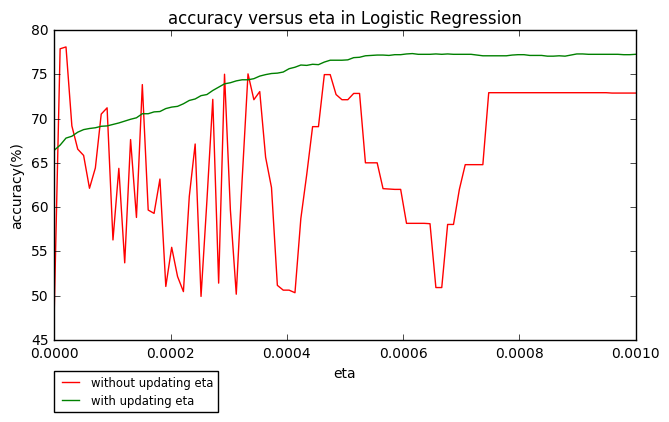

In [30]:
fig,ax = plt.subplots() 
fig.set_size_inches(7.5, 4)
plt.plot(testRange, accurs_origin, 'r', label="without updating eta")
plt.plot(testRange, accurs_update, 'g', label="with updating eta")
plt.xlabel('eta')
plt.ylabel('accuracy(%)')
plt.title("accuracy versus eta in Logistic Regression")
plt.legend(bbox_to_anchor=(0, -0.1), loc=2, borderaxespad=0., fontsize='small')
plt.show()
plt.close()

观察上图，可发现**没有动态更新步长时准确率随着步长的变化会出现严重的抖动情况**，所以动态更新步长是很有必要实现的。

## 在测试集上应用算法
应用最优的 $\eta$ 到测试集上。

In [31]:
bestLR = LogisticRegression()
bestLR.fit(trainSet, trainSet_label, eta=bestEta2, maxRunTimes=10000)
ansLabel = bestLR.apply(testSet)
np.savetxt('15352220_linzecheng.txt', ansLabel, fmt="%d", delimiter="\n")

# 思考题

- 1.如果把梯度为 0 作为算法停止的条件，可能存在怎样的弊端？
    
    - 答：可能会由于梯度始终都在 0 旁边波动而导致算法不会停止。
    

- 2.𝜂 的大小会怎么影响梯度下降的结果？给出具体的解释。

    - 答：𝜂太小可能会导致梯度下降的过程显得比较缓慢；而𝜂太大可能会导致梯度下降的过程一致处于震荡状态，或导致迭代太快而错误最优解。
    
    
- 3.解释批梯度下降和随机梯度下降的优缺点。

    - 答：
        - 从训练速度的角度来看：
            - 随机梯度下降法每次仅仅采用一个样本来迭代，训练速度很快。
            - 批量梯度下降法每次采用整个数据集来迭代，在样本量很大的时候，训练速度很慢。
        - 从准确度的角度来看：
            - 随机梯度下降法仅仅用一个样本决定梯度方向，导致解很有可能不是最优。
            - 批量梯度下降法用整个数据集来决定梯度方向，得到的解相对较优。
        - 从收敛速度的角度来看：
            - 随机梯度下降法一次迭代只用一个样本，可能会导致迭代方向变化很大，不能很快地收敛到局部最优解。
            - 批量梯度下降法每次采用整个数据集来迭代，迭代方向相对较稳定。

# 参考资料

- [概率与似然][1]


[1]:http://blog.csdn.net/fwing/article/details/4850068